In [1]:
!pip install xgboost

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score


In [4]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/2020-2024每日盤後資料.xlsx"
raw = pd.read_excel(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

df = raw.copy()
df = df[(df["契約"] == "TX") & (df["交易時段"] == "盤後")].copy()

df["交易日期"] = pd.to_datetime(df["交易日期"])
df["到期月份"] = df["到期月份(週別)"].astype(str).str.slice(0, 6).astype(int)

for c in ["收盤價", "成交量"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [6]:
def third_wednesday(year: int, month: int) -> pd.Timestamp:
    first = pd.Timestamp(year=year, month=month, day=1)
    # Monday=0 ... Sunday=6 ; Wednesday=2
    offset = (2 - first.weekday()) % 7
    first_wed = first + pd.Timedelta(days=offset)
    return first_wed + pd.Timedelta(days=14)

df["到期年"] = df["到期月份"] // 100
df["到期月"] = df["到期月份"] % 100
df["expiry_date"] = [third_wednesday(int(y), int(m)) for y, m in zip(df["到期年"], df["到期月"])]

df["days_to_expiry"] = (df["expiry_date"] - df["交易日期"]).dt.days


In [7]:
df_sorted = df.sort_values(["交易日期", "成交量"], ascending=[True, False])
top2 = df_sorted.groupby("交易日期").head(2).copy()
top2["rank"] = top2.groupby("交易日期").cumcount() + 1

wide = top2.pivot(index="交易日期", columns="rank", values=["收盤價", "成交量", "到期月份", "days_to_expiry"])
wide.columns = [f"{a}_{b}" for a, b in wide.columns]
wide = wide.sort_index()

data = wide.rename(columns={
    "收盤價_1":"near_price",
    "收盤價_2":"far_price",
    "成交量_1":"near_vol",
    "成交量_2":"far_vol",
    "days_to_expiry_1":"days_to_expiry_near",
    "days_to_expiry_2":"days_to_expiry_far",
    "到期月份_1":"near_month",
    "到期月份_2":"far_month",
}).copy()


In [8]:
data["spread"] = data["near_price"] - data["far_price"]
data["spread_change_5"] = data["spread"] - data["spread"].shift(5)
data["vol_10"] = data["near_price"].pct_change().rolling(10).std()
data["volume_ratio"] = data["near_vol"] / (data["far_vol"] + 1e-9)
data["is_contango"] = (data["spread"] < 0).astype(int)


In [9]:
k = 5
roll_cost_points = 0.0

stay_ret = (data["near_price"].shift(-k) - data["near_price"]) / data["near_price"]
roll_ret = (data["far_price"].shift(-k) - data["far_price"]) / data["far_price"]
cost_ret = roll_cost_points / data["near_price"]

data["excess_roll_ret"] = (roll_ret - cost_ret) - stay_ret
data["label"] = (data["excess_roll_ret"] > 0).astype(int)


In [11]:
N = 10
ml = data[data["days_to_expiry_near"] <= N].dropna().copy()

features = ["spread","spread_change_5","days_to_expiry_near","volume_ratio","vol_10","is_contango"]
X = ml[features]
y = ml["label"]


In [12]:
split = int(len(ml) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=42,
    n_jobs=4
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred))
print("AUC:", roc_auc_score(y_test, proba))


Accuracy: 0.6373626373626373
AUC: 0.7387387387387387


In [13]:
ml["prob_good_roll"] = model.predict_proba(X)[:, 1]

threshold = 0.6
ml["ml_roll_signal"] = (ml["prob_good_roll"] > threshold).astype(int)

ml[["prob_good_roll","ml_roll_signal","excess_roll_ret"]].tail(10)


,prob_good_roll,ml_roll_signal,excess_roll_ret
交易日期,,,
2024-11-19,0.568409,0,0.000208
2024-11-20,0.128451,0,-0.002209
2024-12-09,0.736713,1,0.000522
2024-12-10,0.238002,0,0.000094
2024-12-11,0.436897,0,0.000820
2024-12-12,0.076896,0,-0.000101
2024-12-13,0.011688,0,-0.001251
2024-12-16,0.061035,0,0.000193
2024-12-17,0.054219,0,-0.000243


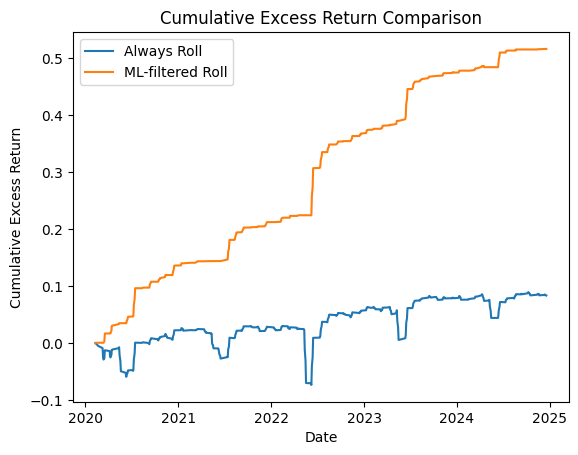

In [14]:
import matplotlib.pyplot as plt

df_plot = ml.copy()

# 原策略：每個候選日都轉
df_plot["ret_always_roll"] = df_plot["excess_roll_ret"]

# ML 策略：只在 ml_roll_signal = 1 時轉
df_plot["ret_ml_roll"] = df_plot["excess_roll_ret"] * df_plot["ml_roll_signal"]

df_plot["cum_always_roll"] = df_plot["ret_always_roll"].cumsum()
df_plot["cum_ml_roll"] = df_plot["ret_ml_roll"].cumsum()

plt.figure()
plt.plot(df_plot.index, df_plot["cum_always_roll"], label="Always Roll")
plt.plot(df_plot.index, df_plot["cum_ml_roll"], label="ML-filtered Roll")
plt.legend()
plt.title("Cumulative Excess Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Excess Return")
plt.show()


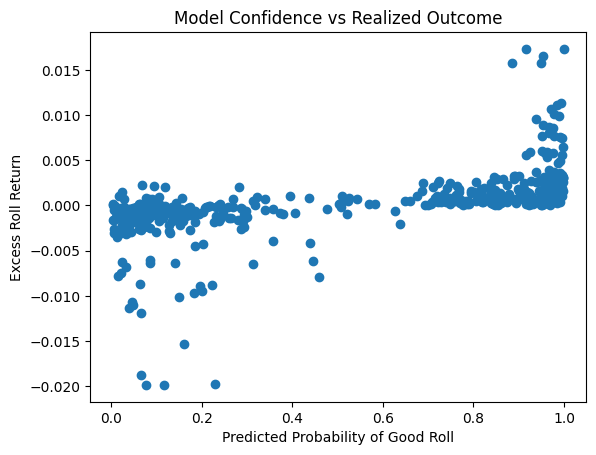

In [15]:
plt.figure()
plt.scatter(ml["prob_good_roll"], ml["excess_roll_ret"])
plt.xlabel("Predicted Probability of Good Roll")
plt.ylabel("Excess Roll Return")
plt.title("Model Confidence vs Realized Outcome")
plt.show()
